In [2]:
from cnn_model import *
from cnn_image import *
from evaluation import *

In [3]:
import time
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [4]:
import os
from evaluation import *
import copy
from os.path import join

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# desired size of the output im
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

In [6]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)
    return path

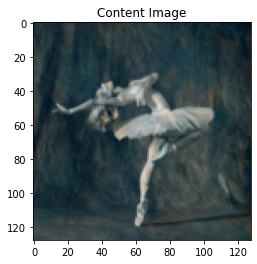

In [7]:
content_img = image_loader("picasso2.jpg")

plt.figure()
imshow(content_img, title='Content Image')

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
def get_imgs_name(file):
    """ Get images name form a txt file

    input:
        file (str): name of the txt file
        path: prefix of the system path

    output:
        names (list): the name of this type of img
        imgs (list): a list store the path of the image
    """
    styles = []
    names = []
    imgs = []

    with open(file, 'r') as f:
        for line in f.readlines():
            s = line.strip('\n').split('/')
            styles.append(s[0])
            s = ''.join(s[1:])
            imgs.append(s)
            names.append(s[:-4])

    return styles, names, imgs

In [10]:
# desired depth layers to compute style/content losses:
default_content_layers = ['conv_4']
default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [15]:
def tansfer(cnn, content_img, style_name, style_img, file,
            num_output = 5,
            default_content_layers = ['conv_4'],
            default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    """
    
    input:
        cnn: the pre train model.
        content_img (tensor)
        style_name (str): like 'blotchy_0003'
        style_img (tensor)
    output:
        out_imgs: the group of new generation pictures
    """
    out_imgs = []
    scores = 0

    # store the style image
    org_image = copy.deepcopy(style_img)
    torchvision.utils.save_image(org_image, file + '/' + style_name + '_0.jpg')

    times = []
    for i in range(num_output):
        input_img = generate_input_image(noise = True, content_img=content_img)

        output, g, time = style_transfer(cnn, content_img, style_img, input_img,
        default_mean_std = False, 
        num_steps=300, 
        style_weight=1000000, 
        content_weight=1)
        times.append(time)

        # save fig
        out_imgs.append(output)
        save_name = '{}_{}'.format(style_name, i + 1)
        torchvision.utils.save_image(output, file + '/{}.jpg'.format(save_name))

    #times = np.array(times)
    times = np.mean(times, 0)
    # plot the time
    plt.figure()
    plt.scatter(range(len(times))[::10], times[::10], 
        marker='x', linewidths=1, label = style_name)
    plt.xlabel('Iteration Times')
    plt.ylabel('Running Time')
    plt.title(style_name)
    plt.legend()
    plt.savefig(file + '/{} time'.format(style_name))

    return out_imgs

In [16]:
def generate_compare(cnn, content_img, txt_file, saving_path,
        img_path = '../src/dtd/images/',
        num_output = 5,
        default_content_layers = ['conv_4'],
        default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
        """
        input: 
            content_img (tensor)
            txt_file (str): store the texture we want to generate
            saving_path (str): the path we want to save our pictures
        """

        styles, names, imgs = get_imgs_name(txt_file)


        for style, name, img in zip(styles, names, imgs):
            #this_saving_path = saving_path + '/' + name
            style_name = style
            img_name = name

            style_img = image_loader(img_path + style + '/'+ img)

            save_folder = mkdir(saving_path + img_name)

            out_images = tansfer(cnn, 
                                    content_img, 
                                    img_name, 
                                    style_img,
                                    save_folder,num_output)

            loss = 0

            g = str('../transfered_output/'+img_name)
            
            img_original = None
            imgs_generated = []
            for fname in os.listdir(g):
                if fname[-5] == '0':
                    img_original = join(g, fname)
                elif fname[-5] not in ['e', 'c'] and int(fname[-5]) > 0:
                    imgs_generated.append(join(g, fname))

            for out in imgs_generated:
                l = evaluation(cnn, img_original, out)
                loss += l
                
            loss /= len(out_images)
            loss = round(loss, 4)

            with open(saving_path + '/scores'+'/scores','a+') as f:
                f.write(img_name + ' ' + str(loss) + '\n')

In [18]:
txt_file = '../test/test2.txt'
# with open('../transfered_output/scores/scores','r+') as f:
#     f.truncate()
generate_compare(cnn, content_img, 
                #txt_file = '../test/test_blotchy1.txt',
                txt_file = txt_file, 
                saving_path = '../transfered_output/',
                num_output = 1,
                default_content_layers = ['conv_4'],
                default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 58.932186 Content Loss: 38.269493

run [100]:
Style Loss : 16.833179 Content Loss: 30.561443

run [150]:
Style Loss : 7.223070 Content Loss: 24.593941

run [200]:
Style Loss : 3.366625 Content Loss: 20.889517

run [250]:
Style Loss : 2.284168 Content Loss: 18.842663

run [300]:
Style Loss : 1.944090 Content Loss: 17.719473



FileNotFoundError: [Errno 2] No such file or directory: '../transfered_output//scores/scores'

In [127]:
# import os
# from os.path import join
# g = '../transfered_output/banded_0002'

# img_original = None
# imgs_generated = []
# for fname in os.listdir(g):
#     if fname[-5] == '0':
#         img_original = join(g, fname)
#     elif fname[-5] not in ['e', 'c'] and int(fname[-5]) > 0:
#         imgs_generated.append(join(g, fname))

# img_original, imgs_generated


('../transfered_output/banded_0002/banded_0002_0.jpg',
 ['../transfered_output/banded_0002/banded_0002_1.jpg',
  '../transfered_output/banded_0002/banded_0002_3.jpg',
  '../transfered_output/banded_0002/banded_0002_2.jpg'])

In [16]:
# evaluation(cnn,'../transfered_output/banded_0002/banded_0002_0.jpg','../transfered_output/banded_0002/banded_0002_2.jpg')

26115.89453125